In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from ord2011 import ORD2011

In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
current_li = ['I_Na', 'I_NaL', 'I_to', 'I_CaL', 'I_Kr', 'I_Ks', 'I_K1' ]         
protocol = vc_protocols.hERG_CiPA()
end_time = 1000 #protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 10000)
print(end_time)

1000


In [3]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
model_myokit, protocol_myokit = protocol_lib.transform_to_myokit_protocol( protocol, model_myokit )
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol_myokit, max_step=1e-5*1000, abs_tol=1e-12, rel_tol=1e-12, vhold=-87)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "ORD2011"

In [4]:
start_time = time.time()

sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
# y0_myokit = sim_myokit.pre_simulate(100, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=None, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'])

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.1725010871887207 seconds ---


In [5]:
import simulator_scipy
'''
Simulation with Scipy
'''
model_scipy = ORD2011(protocol)
sim_scipy = simulator_scipy.Simulator(model_scipy)

start_time = time.time()

model_scipy.cell.mode = cells['Epicardial']
# model_scipy.y0[1:] = y0_myokit
# y0 = sim_bdf.pre_simulate( pre_step=bcl*100, protocol='constant' )   
sol_scipy = sim_scipy.simulate(t_span=t_span, t_eval=None, method='BDF', max_step=1e-5*1000, atol=1e-8, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1E-3*self.time_conversion,  atol=1E-2, rtol=1E-4

print("--- %s seconds ---"%(time.time()-start_time))

--- 72.92070889472961 seconds ---


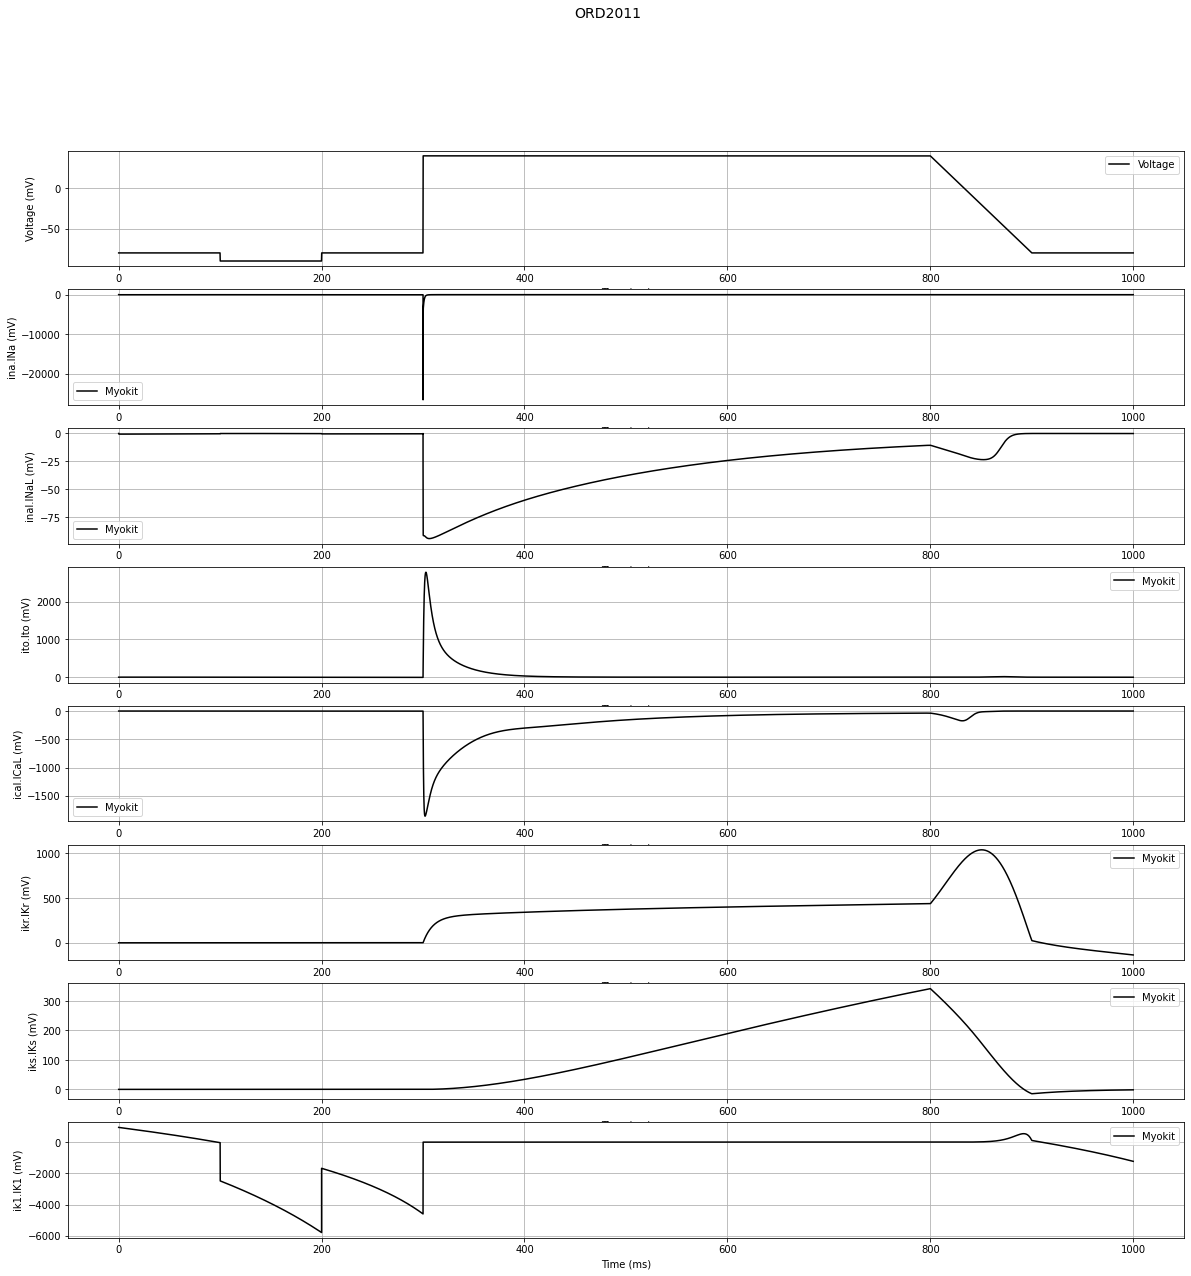

In [8]:
'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(20,20))    
fig.suptitle(model_scipy.name, fontsize=14)
plot_li = ['Voltage'] + ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']
for i, name in enumerate(plot_li):
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if name=='Voltage':
        axes[i].plot( t_eval, protocol.get_voltage_clamp_protocol(t_eval), label=name, color='k')   
    else:
        # axes[i].plot( model_scipy.current_response_info.get_current([name]), label=name, color='k')   
        axes[i].plot( d_myokit['engine.time'], d_myokit[name]*1000, label='Myokit', color='k') 
    # axes[i].plot(model_euler.times, model_euler.current_response_info.get_current(['I_Kr']), label='Euler')   
    axes[i].legend()
    axes[i].grid()


plt.show()
fig.savefig(os.path.join('Results', "ORD2011-all"), dpi=100)

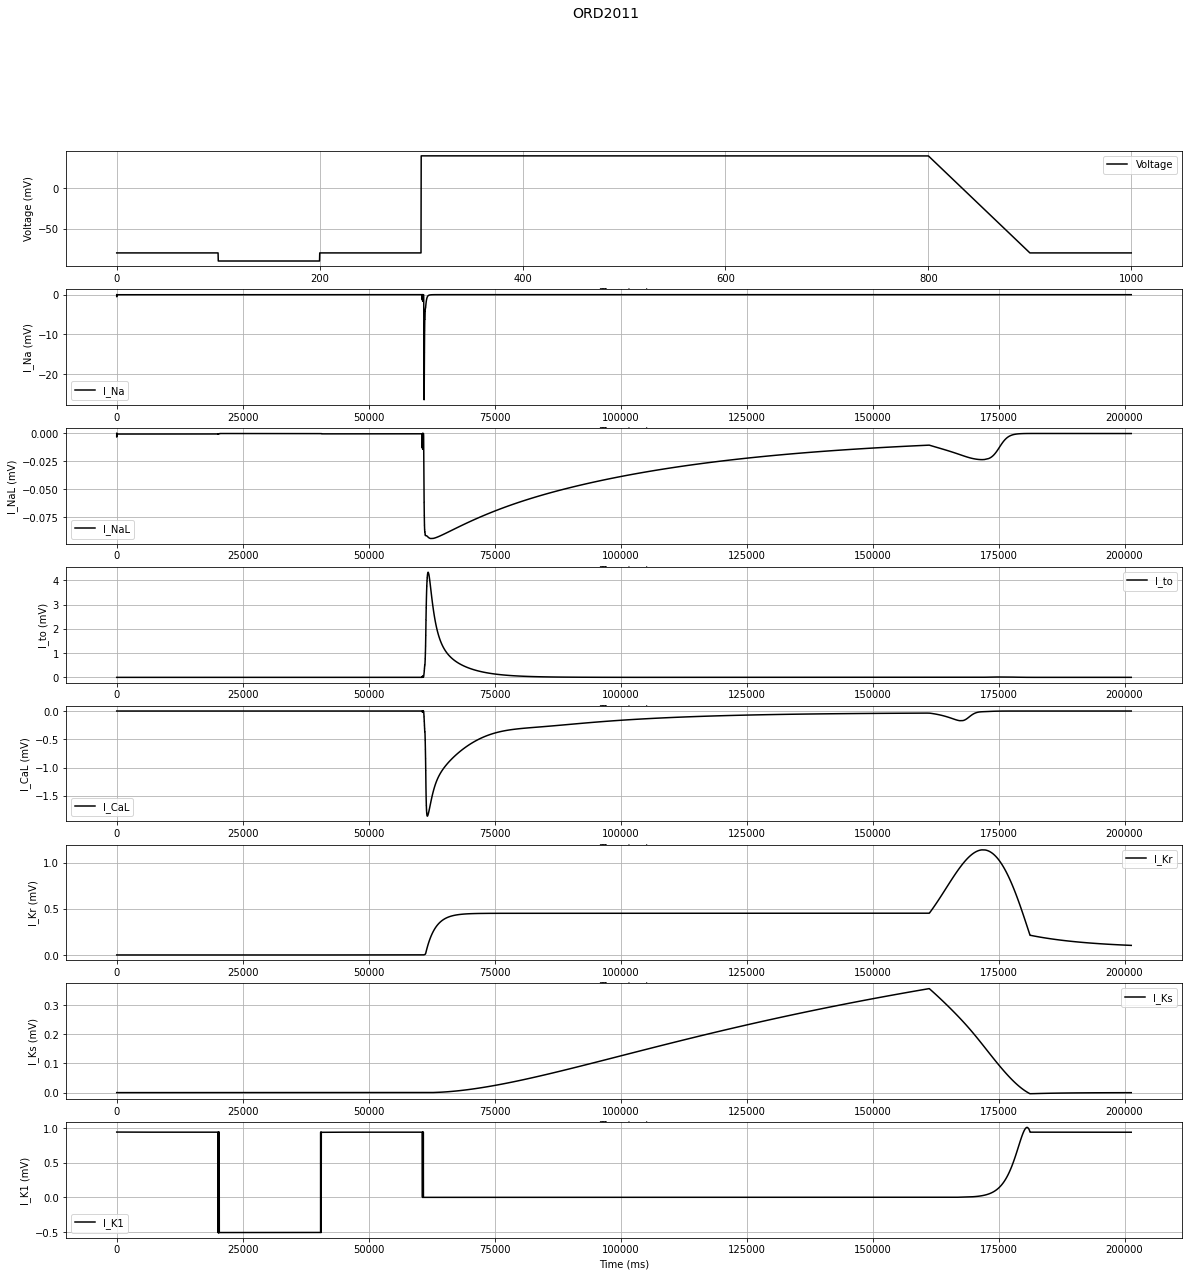

In [9]:
'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(20,20))    
fig.suptitle(model_scipy.name, fontsize=14)
plot_li = ['Voltage'] + current_li
for i, name in enumerate(plot_li):
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if name=='Voltage':
        axes[i].plot( t_eval, protocol.get_voltage_clamp_protocol(t_eval), label=name, color='k')   
    else:
        axes[i].plot( model_scipy.current_response_info.get_current([name]), label=name, color='k')   
        # axes[i].plot( d_myokit['engine.time'], d_myokit['ikr.IKr']*1000, label='Myokit', color='k') 
    # axes[i].plot(model_euler.times, model_euler.current_response_info.get_current(['I_Kr']), label='Euler')   
    axes[i].legend()
    axes[i].grid()


plt.show()
fig.savefig(os.path.join('Results', "ORD2011-all"), dpi=100)

In [10]:
print("Complete")

Complete
